# Image Classification

We show in this tutorial how to use DRAGON for image classification task. We need to create a search space with two graphs, one treating 2D data, and a second one treating 1D data.

## Loading the dataset

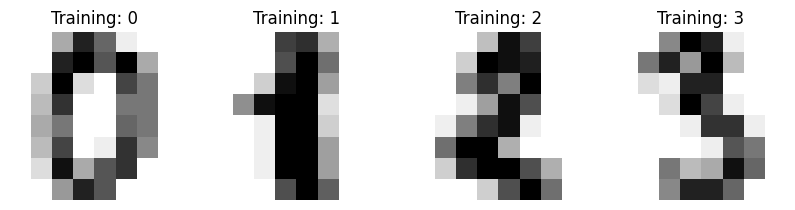

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)


In [2]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    digits.images, digits.target, test_size=0.5, shuffle=False
)

X_train = X_train/digits.images.max()
X_test = X_test/digits.images.max()

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_test.shape}, y_val: {y_test.shape}")

X_train: (898, 8, 8), y_train: (898,), X_val: (899, 8, 8), y_val: (899,)


## Defining the Loss function

#### DNN definition

In [3]:
import torch
import torch.nn as nn
import numpy as np
import os 

class ClassificationDNN(nn.Module):
    def __init__(self, args, input_shape) -> None:
        super().__init__()
        self.input_shape = input_shape
        self.dag_2d = args['2D Dag']
        self.dag_2d.set(self.input_shape)

        flat_shape = (np.prod(self.dag_2d.output_shape),)
        self.dag_1d = args['1D Dag']
        self.dag_1d.set(flat_shape)

        self.output = args["Out"]
        self.output.set(self.dag_1d.output_shape)

    def forward(self, X, **kwargs):
        out_2d = self.dag_2d(X)
        flat = nn.Flatten()(out_2d)
        out_1d = self.dag_1d(flat)
        out = self.output(out_1d)
        return out

    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        full_path = os.path.join(path, "best_model.pth")
        torch.save(self.state_dict(), full_path)

### Search Space Definition

In [4]:
from dragon.search_space.bricks_variables import mlp_var, dropout, identity_var, operations_var, mlp_const_var, conv_2d, pooling_2d, dag_var, node_var
from dragon.search_space.base_variables import ArrayVar
from dragon.search_operators.base_neighborhoods import ArrayInterval

candidate_operations_2d = operations_var("2D Candidate operations", size=10, 
                                            candidates=[mlp_var("MLP"), identity_var("Identity"), dropout('Dropout'), conv_2d('Conv 2d', max_out=8), pooling_2d("Pooling")])
dag_2d = dag_var("2D Dag", candidate_operations_2d)

candidate_operations_1d = operations_var("1D Candidate operations", size=10, 
                                            candidates=[mlp_var("MLP"), identity_var("Identity"), dropout('Dropout')])
dag_1d = dag_var("1D Dag", candidate_operations_1d)
out = node_var("Out", operation=mlp_const_var('Operation', 10), activation_function=nn.Identity())

search_space = ArrayVar(dag_2d, dag_1d, out, label="Search Space", neighbor=ArrayInterval())

### DNN Training

In [5]:
import numpy as np
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score
from dragon.utils.tools import set_seed

device = "cuda" if torch.cuda.is_available() else "cpu"

def train_and_predict(args, idx, verbose=False):
    set_seed(0)
    labels = [e.label for e in search_space]
    args = dict(zip(labels, args))
    model = ClassificationDNN(args, input_shape=(8,8,1))
    trainer = NeuralNetClassifier(
        model,
        max_epochs=20,
        lr=0.01,
        optimizer = torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        iterator_train__shuffle=True,
        verbose=verbose,
        device=device
    )
    X_train_torch = torch.tensor(np.expand_dims(X_train.astype(np.float32), axis=-1)).to(device)
    y_train_torch = torch.tensor(y_train.astype(np.int64)).to(device)
    X_test_torch = torch.tensor(np.expand_dims(X_test.astype(np.float32), axis=-1)).to(device)
    trainer.fit(X_train_torch, y_train_torch)
    y_pred = trainer.predict(X_test_torch)
    acc = accuracy_score(y_test, y_pred)
    print(f"With idx = {idx}, accuracy = {acc}")
    return - acc, model # We are optimizing a minimization problem

p1, p2 = search_space.random(2)

loss_1, model_1 = train_and_predict(p1,idx="p1", verbose=True)
loss_2, model_2 = train_and_predict(p2, idx="p2", verbose=True)

print("P1 ==> accuracy: ", np.round(-loss_1*100,2), "%\n")
print("P2 ==> accuracy: ", np.round(-loss_2*100,2), "%")

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1       10.4300       0.1000       35.2483  0.6397
      2       17.3778       0.1389       21.8782  0.5451
      3       10.0463       0.3056       11.8703  0.5422
      4        3.7305       0.3222        7.0649  0.5363
      5        2.4646       0.6556        2.2861  0.5357
      6        1.1765       0.5500        3.7344  0.5302
      7        0.8276       0.6778        2.2579  0.5375
      8        0.4357       0.7778        2.0746  0.5252
      9        0.3695       0.7889        1.5015  0.5352
     10        0.2913       0.7444        2.1330  0.5405
     11        0.2722       0.7611        1.4074  0.5306
     12        0.2230       0.7167        1.9679  0.5648
     13        0.1919       0.8056        1.2097  0.5308
     14        0.1777       0.7833        1.6146  0.5378
     15        0.1509       0.8222        1.0433  0.5347
     16        0.1600       0.7

### Implementing an optimization strategy


In [6]:
import time
from dragon.search_algorithm.ssea import SteadyStateEA

search_algorithm = SteadyStateEA(search_space, n_iterations=20, population_size=5, selection_size=3, evaluation=train_and_predict, save_dir="save/test_image/")
start_time = time.time()
search_algorithm.run()
min_loss = search_algorithm.min_loss
end_time = time.time() - start_time
print(f"Best score: {np.round(-min_loss*100,2)}%\nComputation time: {np.round(end_time,2)} seconds")

2025-02-24 11:02:28,574 | WARNING | Install mpi4py if you want to use the distributed version.
2025-02-24 11:02:28,578 | INFO | save/test_image/ already exists. Deleting it.
2025-02-24 11:02:28,609 | INFO | The whole population has been created (size = 5), 5 have been randomy initialized.
With idx = 0, accuracy = 0.10122358175750834
2025-02-24 11:02:33,894 | INFO | Best found! -0.10122358175750834 < inf
With idx = 1, accuracy = 0.9365962180200222
2025-02-24 11:02:35,145 | INFO | Best found! -0.9365962180200222 < -0.10122358175750834
With idx = 2, accuracy = 0.8787541713014461
With idx = 3, accuracy = 0.09788654060066741
With idx = 4, accuracy = 0.10122358175750834
2025-02-24 11:03:03,601 | INFO | All models have been at least evaluated once, t = 5 < 20.
2025-02-24 11:03:03,603 | INFO | After initialisation, it remains 15 iterations.
2025-02-24 11:03:03,673 | INFO | Evolving 1 and 2 to 6 and 7
With idx = 7, accuracy = 0.10122358175750834
2025-02-24 11:03:05,516 | INFO | Replacing 3 by 7

Starting with a completely random sets of DNNs, we managed in a few minutes to converge towards an accuracy higher than 92%.

In [7]:
from dragon.utils.plot_functions import load_archi
set_seed(0)
best_args =load_archi('save/test_image/best_model/x.pkl')
labels = [e.label for e in search_space]
best_args = dict(zip(labels, best_args))
model = ClassificationDNN(best_args, (8,8,1))
model.load_state_dict(torch.load('save/test_image/best_model/best_model.pth'))

model = NeuralNetClassifier(
    model,
    max_epochs=1,
    lr=0.0001,
    iterator_train__shuffle=True,
    verbose=False,
    
)
model.fit(np.expand_dims(X_train.astype(np.float32), axis=-1), y_train.astype(np.int64))
y_pred = model.predict(np.expand_dims(X_test.astype(np.float32), axis=-1))
acc = accuracy_score(y_test, y_pred)

print("Final accuracy: ", np.round(acc*100,2), "%\n")

Final accuracy:  94.55 %



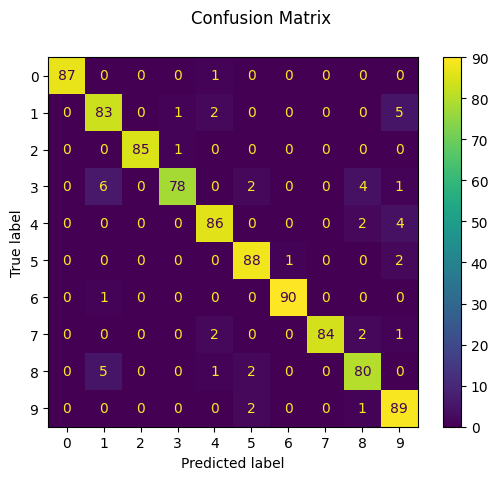

In [8]:
from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

Model giving a score of 94.55%:


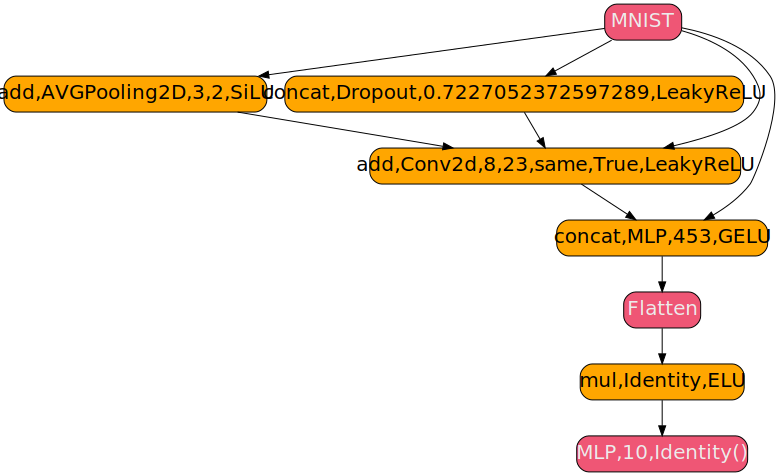

In [9]:
import graphviz
from dragon.utils.plot_functions import draw_cell, str_operations

def draw_graph(n_dag2, m_dag2, n_dag1, m_dag1, output_file, act="Identity()", name="MNIST"):
    G = graphviz.Digraph(output_file, format='pdf',
                            node_attr={'nodesep': '0.02', 'shape': 'box', 'rankstep': '0.02', 'fontsize': '20', "fontname": "sans-serif"})

    G, g_nodes = draw_cell(G, n_dag2, m_dag2, "#ffa600", [], name_input=name,
                            color_input="#ef5675")
    G.node("Flatten", style="rounded,filled", color="black", fillcolor="#CE1C4E", fontcolor="#ECECEC")
    G.edge(g_nodes[-1], "Flatten")

    G, g_nodes = draw_cell(G, n_dag1, m_dag1, "#ffa600", g_nodes, name_input=["Flatten"],
                            color_input="#ef5675")

    G.node(','.join(["MLP", "10", act]), style="rounded,filled", color="black", fillcolor="#ef5675", fontcolor="#ECECEC")
    G.edge(g_nodes[-1], ','.join(["MLP", "10", act]))
    return G

m_dag2 = best_args['2D Dag'].matrix
n_dag2 = str_operations(best_args["2D Dag"].operations)

m_dag1 = best_args['1D Dag'].matrix
n_dag1 = str_operations(best_args["1D Dag"].operations)

graph = draw_graph(n_dag2, m_dag2, n_dag1, m_dag1, "save/test_image/best_archi")
print(f'Model giving a score of {np.round(acc*100,2)}%:')
graph